In [1]:
from nutils import*
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import collections, colors
import os

In [8]:
def CreateBackgroundMesh(L, N):
    # domain size
    Lx = L
    Ly = L

    # elements
    Nx = N
    Ny = N

    x = np.linspace(0, L, Nx+1)
    y = np.linspace(0, L, Ny+1)

    topo, geom = mesh.rectilinear([x,y])\
    
    return topo, geom

def RefineBySDF(topo, sdf, nrefine):
    refined_topo = topo
    for n in range(nrefine):
        elems_to_refine = []
        k = 0
        bez = refined_topo.sample('bezier',2)
        sd = bez.eval(sdf)
        sd = sd.reshape( [len(sd)//4, 4] )
        for i in range(len(sd)):
            if any(np.sign(sdval) != np.sign(sd[i][0]) for sdval in sd[i,:]):
                elems_to_refine.append(k)
            k = k + 1
        refined_topo = refined_topo.refined_by(refined_topo.transforms[np.array(elems_to_refine)])
    return refined_topo

def SetupBackgroundMesh(L, N, ri, ro):
    # define namespace
    ns = function.Namespace()
    ns.ri = ri
    ns.ro = ro
    topo, ns.x = CreateBackgroundMesh(L, N)
    
    # define indicator function
    class CylinderWallIndicator(function.Pointwise):
        @staticmethod
        def evalf(x,y):
            return np.heaviside(x**2 + y**2 - ri**2 ,1) - np.heaviside(x**2 + y**2 - ro**2 ,0)

    # add to the namespace
    ns.wall = CylinderWallIndicator(ns.x[0], ns.x[1])
    
    # add signed distance fields
    ns.sdfri = 'x_i x_i - ri^2'
    ns.sdfro = 'x_i x_i - ro^2'
    
    return topo, ns

def SetupImmersedBoundaryMesh(N, ri, pi):
    ns = function.Namespace()

    u = np.linspace(0, np.pi / 2, N+1)

    topo, ns.u = mesh.rectilinear([u])
    
    ns.pi = pi
    ns.ri = ri

    n_verts = len(u)
    x_verts = [0]*(n_verts)
    y_verts = [0]*(n_verts)

    t_x = [0]*(n_verts)
    t_y = [0]*(n_verts)

    k = 0
    for i in range(len(u)):
        x_verts[k] = ri * np.cos(u[i])
        y_verts[k] = ri * np.sin(u[i])
        t_x[k] = pi * np.cos(u[i])
        t_y[k] = pi * np.sin(u[i])
        k = k + 1

    ns.linbasis = topo.basis('spline',degree=1)
    ns.xx = ns.linbasis.dot(x_verts)
    ns.xy = ns.linbasis.dot(y_verts)
    ns.tx = ns.linbasis.dot(t_x)
    ns.ty = ns.linbasis.dot(t_y)
    ns.x_i = '<xx, xy>_i'
    ns.traction_i = '<tx, ty>_i'
    
    ns.tractionexact_i = '< pi cos(u_0), pi sin(u_0) >_i'
    ns.xexact_i = '< ri cos(u_0), ri sin(u_0) >_i'
    
    
    return topo, ns

def GetColorMap():
    cols = [(0.9, 0.9, 0.9), (0.5, 0.5, 0.5)]
    nbins = 100
    cmap = colors.LinearSegmentedColormap.from_list('custom', cols, N=nbins)
    return cmap

def PlotMesh(ax, topo, geom, shading=0, res=100, linewidth=1, linecolor='k'):
    bezier = topo.sample('bezier', res)
    x, col = bezier.eval([geom,shading])
    cmap = GetColorMap()
    ax.tripcolor(x[:,0], x[:,1], bezier.tri, col, cmap=cmap, shading='gouraud', rasterized=True)
    ax.add_collection(collections.LineCollection(x[bezier.hull], colors=linecolor, linewidth=linewidth, alpha=1))
    return ax

def PlotWireframe(ax, topo, geom, res=2, linewidth=1, linecolor='k'):
    bezier = topo.sample('bezier', res)
    x = bezier.eval(geom)
    ax.add_collection(collections.LineCollection(x[bezier.hull], colors=linecolor, linewidth=linewidth, alpha=1))
    return ax

def PlotLine(ax, topo, geom, res=2, linewidth=1, linecolor='k'):
    bez = topo.sample('bezier',res)
    verts = bez.eval(geom)
    ax.plot(verts[:,0] , verts[:,1] , color=linecolor, linewidth=linewidth)
    return ax
    
def PlotVectors(ax, topo, geom, v, res=2, scale=1.0, color='b', width=0.001, headwidth=5):
    bez = topo.sample('bezier',res)
    verts = bez.eval(geom)
    arrows = bez.eval(v)
    for vert, arrow in zip(verts, arrows):
        ax.arrow(vert[0] - scale * arrow[0], vert[1] - scale * arrow[1], scale * arrow[0], scale * arrow[1], width=width, head_width=headwidth*width, color=color, length_includes_head=True)
    return ax

def ExportPlot(fig, ax, fdir, fname):
    fext = ".png"
    fpath = fdir + "/" + fname + fext
    if not os.path.exists(fdir):
        os.makedirs(fdir)
    fig.savefig(fpath, dpi=300)
    print("saved " + fpath)

def NewFigure():
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    return fig, ax

In [9]:
N = 5
L = 1
ri = L / 3
ro = 2 * L / 3
pi = 0.012
omega_topo, omega = SetupBackgroundMesh(L, N, ri, ro)

In [10]:
# refinement params
nref = 2
nqref = 2

# refine background topology for basis
refined_omega_topo = RefineBySDF(omega_topo, omega.sdfri, nref)

# refine background topology for quadrature rule
refined_quadrature_topo = RefineBySDF(refined_omega_topo, omega.sdfri, nqref)
refined_quadrature_topo = RefineBySDF(refined_quadrature_topo, omega.sdfro, nqref + nref)

In [11]:
# Construct Quadrature Rule
deg = 2
gauss = refined_quadrature_topo.sample('gauss', deg)
gpts = gauss.eval(omega.x)

In [12]:
# Plotting params
fdir = "Figures"

saved Figures/background_mesh_cyl.png


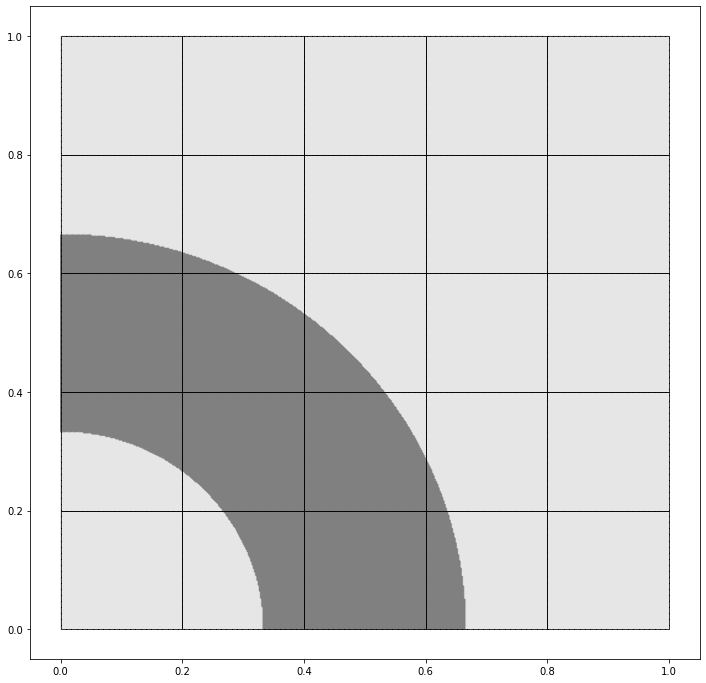

In [7]:
# Plot Background Mesh
fig, ax = NewFigure()
fname = "background_mesh_cyl"
PlotMesh(ax, omega_topo, omega.x, shading=omega.wall)
ExportPlot(fig, ax, fdir, fname)

saved Figures/background_mesh.png


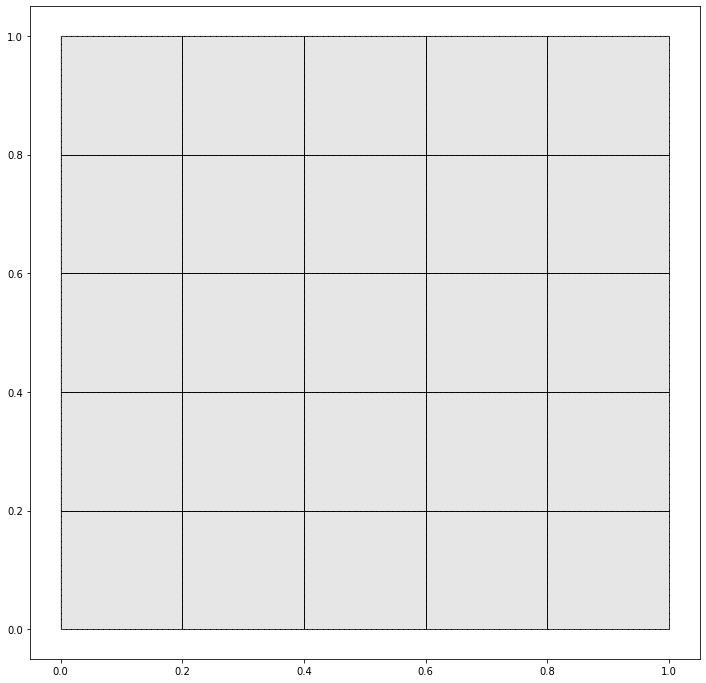

In [8]:
# Plot Background Mesh
fig, ax = NewFigure()
fname = "background_mesh"
PlotMesh(ax, omega_topo, omega.x)
ExportPlot(fig, ax, fdir, fname)

saved Figures/refined_background_mesh_cyl.png


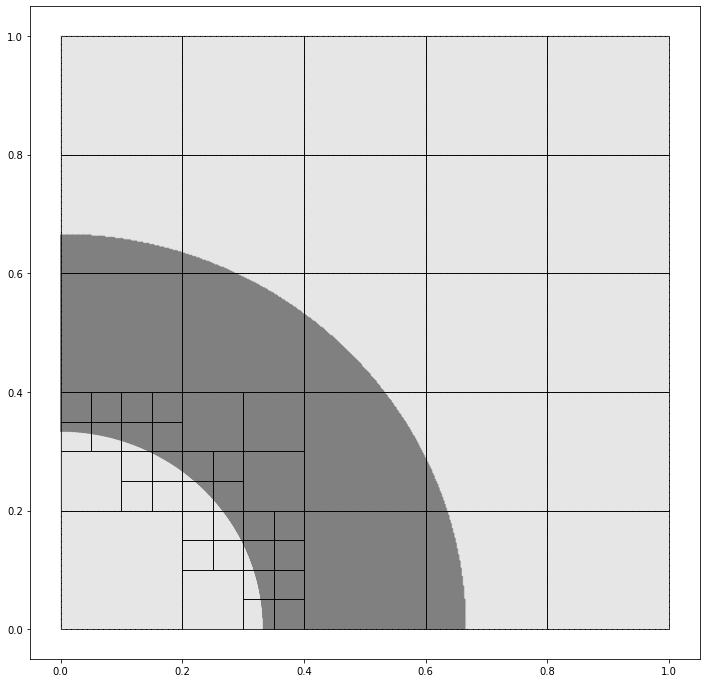

In [9]:
# Plot Locally Refined Mesh
fig, ax = NewFigure()
fname = "refined_background_mesh_cyl"
PlotMesh(ax, refined_omega_topo, omega.x, shading=omega.wall)
ExportPlot(fig, ax, fdir, fname)

saved Figures/refined_background_mesh.png


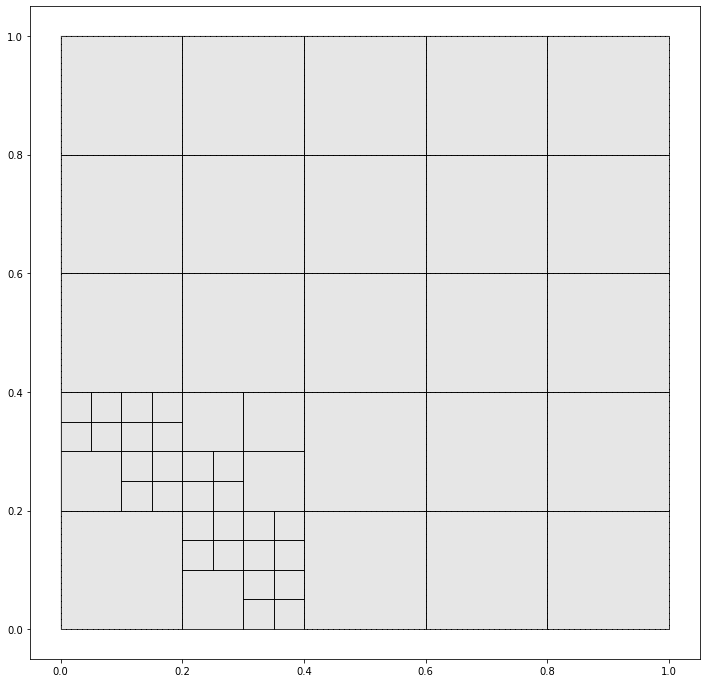

In [10]:
# Plot Locally Refined Mesh
fig, ax = NewFigure()
fname = "refined_background_mesh"
PlotMesh(ax, refined_omega_topo, omega.x)
ExportPlot(fig, ax, fdir, fname)

saved Figures/refined_quadrature_mesh_cyl.png


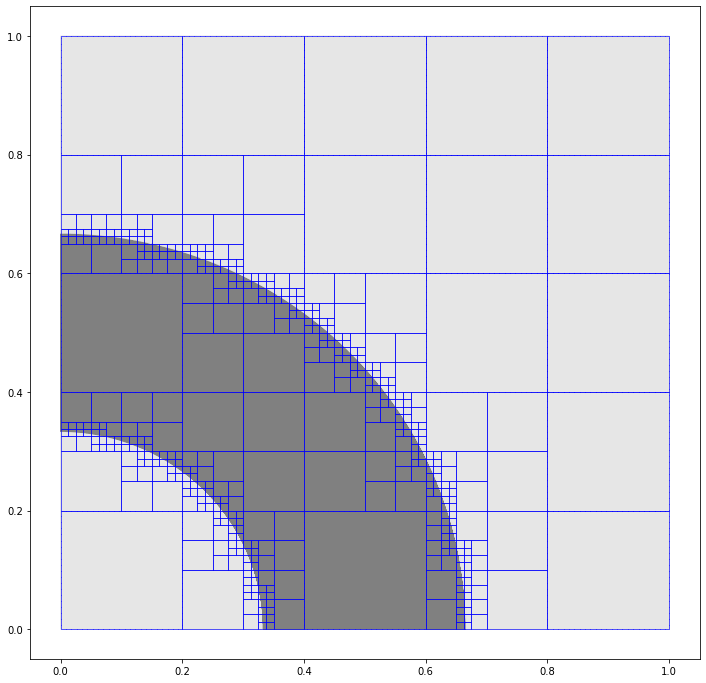

In [13]:
# Plot Refined Quadrature Mesh
fig, ax = NewFigure()
fname = "refined_quadrature_mesh_cyl"
PlotMesh(ax, refined_quadrature_topo, omega.x, shading=omega.wall, linewidth=0.8, linecolor='b')
ExportPlot(fig, ax, fdir, fname)

saved Figures/refined_quadrature_mesh_and_analysis_mesh_cyl.png


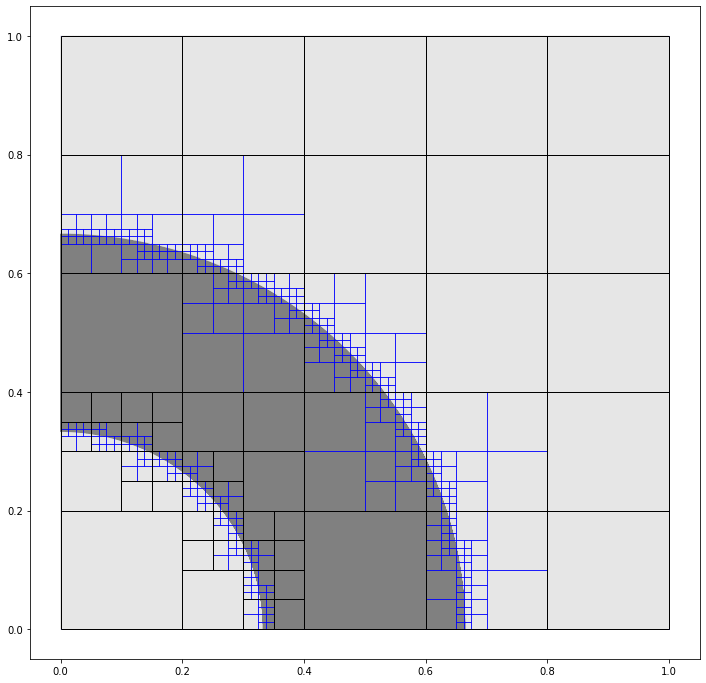

In [14]:
# Plot Refined Quadrature Mesh
fig, ax = NewFigure()
fname = "refined_quadrature_mesh_and_analysis_mesh_cyl"
PlotMesh(ax, refined_quadrature_topo, omega.x, shading=omega.wall, linewidth=0.8, linecolor='b')
PlotWireframe(ax, refined_omega_topo, omega.x)
ExportPlot(fig, ax, fdir, fname)

saved Figures/refined_quadrature_mesh.png


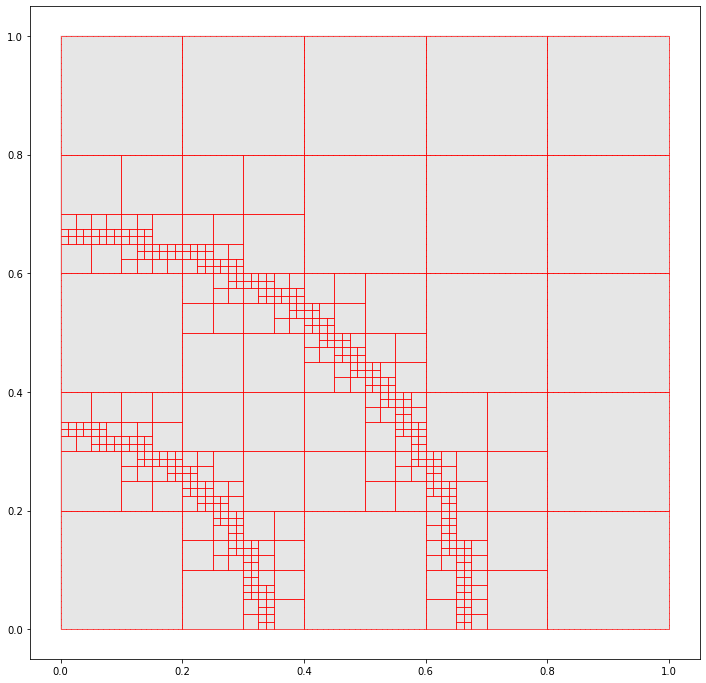

In [12]:
# Plot Refined Quadrature Mesh
fig, ax = NewFigure()
fname = "refined_quadrature_mesh"
PlotMesh(ax, refined_quadrature_topo, omega.x, linewidth=0.8, linecolor='r')
ExportPlot(fig, ax, fdir, fname)

saved Figures/refined_mesh_with_refined_gpts.png


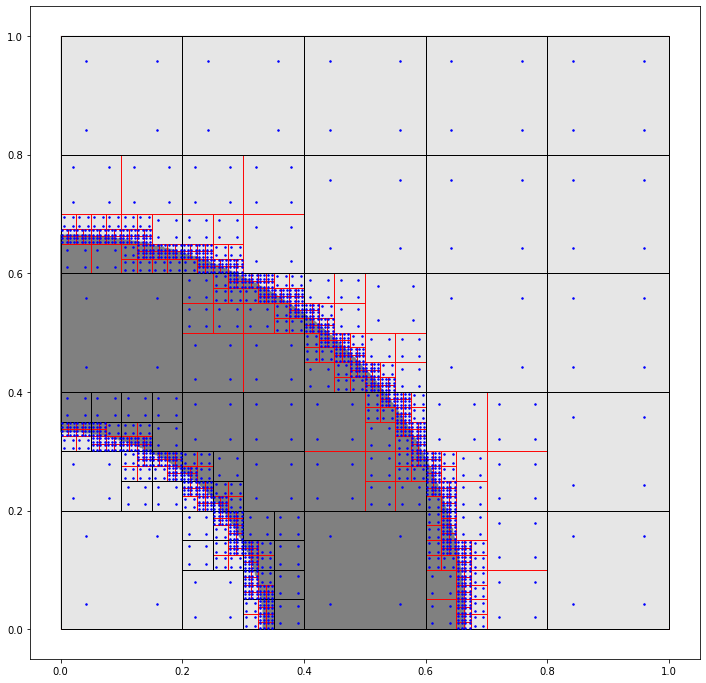

In [13]:
# Plot Mesh with Quadrature Points
fig, ax = NewFigure()
fname = "refined_mesh_with_refined_gpts"
PlotMesh(ax, omega_topo, omega.x, shading=omega.wall)
PlotWireframe(ax, refined_quadrature_topo, omega.x, linewidth=0.8, linecolor='r')
PlotWireframe(ax, refined_omega_topo, omega.x)
ax.plot(gpts[:,0],gpts[:,1], '.', markersize=3, color='b')
ExportPlot(fig, ax, fdir, fname)

saved Figures/refined_mesh_with_refined_gpts_no_quadrature_wireframe.png


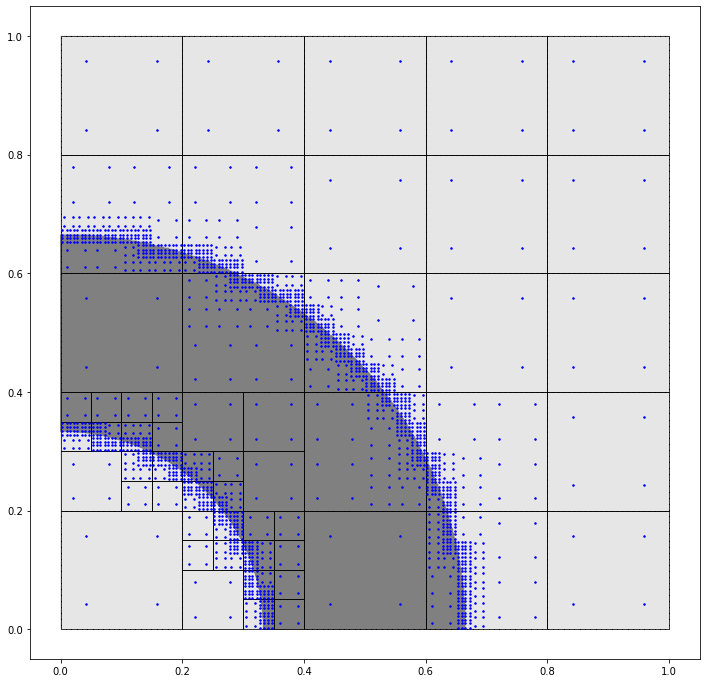

In [14]:
# Plot Mesh with Quadrature Points
fig, ax = NewFigure()
fname = "refined_mesh_with_refined_gpts_no_quadrature_wireframe"
PlotMesh(ax, refined_omega_topo, omega.x, shading=omega.wall)
ax.plot(gpts[:,0],gpts[:,1], '.', markersize=3, color='b')
ExportPlot(fig, ax, fdir, fname)

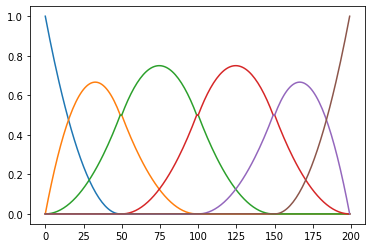

In [15]:
# Basis Plotting
p = 2
topo, geom = mesh.rectilinear([np.linspace(0,1,N)])
basis = topo.basis('spline',degree=p)
bezier = topo.sample('bezier',50)
basisvals = bezier.eval(basis)
plt.plot(basisvals)

In [16]:
# Setup Immersed Boundary
n = 5
gamma_topo, gamma = SetupImmersedBoundaryMesh(n, ri, pi)

saved Figures/cyl_immersed_boundary_exact_geometry.png


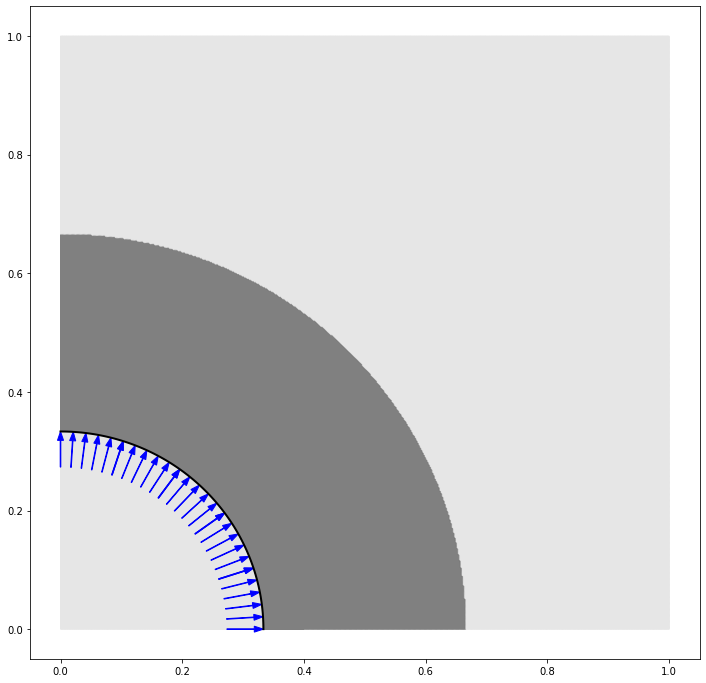

In [17]:
# Plot cylinder with immersed boundary mesh

fig, ax = NewFigure()
fname = "cyl_immersed_boundary_exact_geometry"
PlotMesh(ax, refined_omega_topo, omega.x, shading=omega.wall, linewidth=0)
PlotLine(ax, gamma_topo, gamma.xexact, res=20, linecolor='k', linewidth=2.0)
PlotVectors(ax, gamma_topo, gamma.xexact, gamma.tractionexact, res=6, scale=5, color='b', width=0.001, headwidth=10)


ExportPlot(fig, ax, fdir, fname)

saved Figures/cyl_immersed_boundary.png


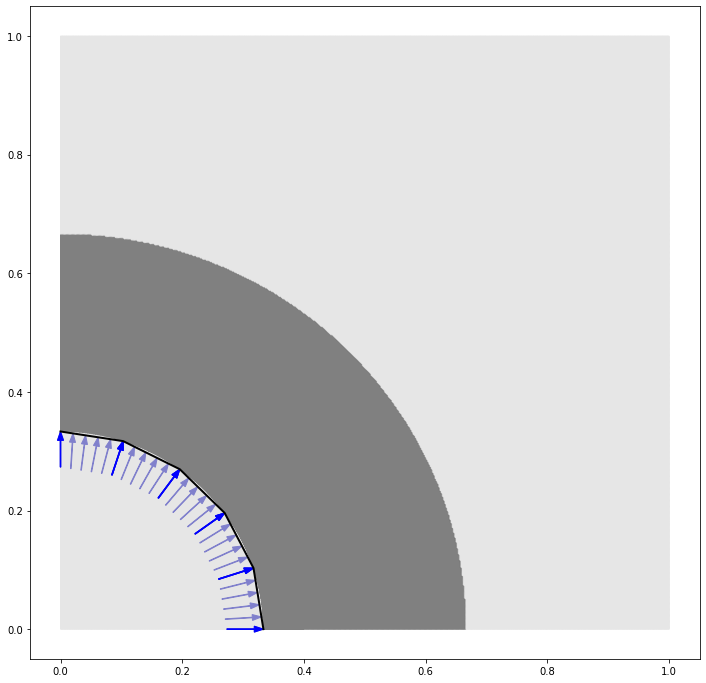

In [18]:
# Plot cylinder with immersed boundary mesh

fig, ax = NewFigure()
fname = "cyl_immersed_boundary"
PlotMesh(ax, refined_omega_topo, omega.x, shading=omega.wall, linewidth=0)
PlotLine(ax, gamma_topo, gamma.x, linecolor='k', linewidth=2.0)
PlotVectors(ax, gamma_topo, gamma.x, gamma.traction, res=6, scale=5, color=(0.5,0.5,0.8), width=0.001, headwidth=10)
PlotVectors(ax, gamma_topo, gamma.x, gamma.traction, res=2, scale=5, color='b', width=0.001, headwidth=10)


ExportPlot(fig, ax, fdir, fname)

saved Figures/cyl_immersed_boundary_and_background_meshes.png


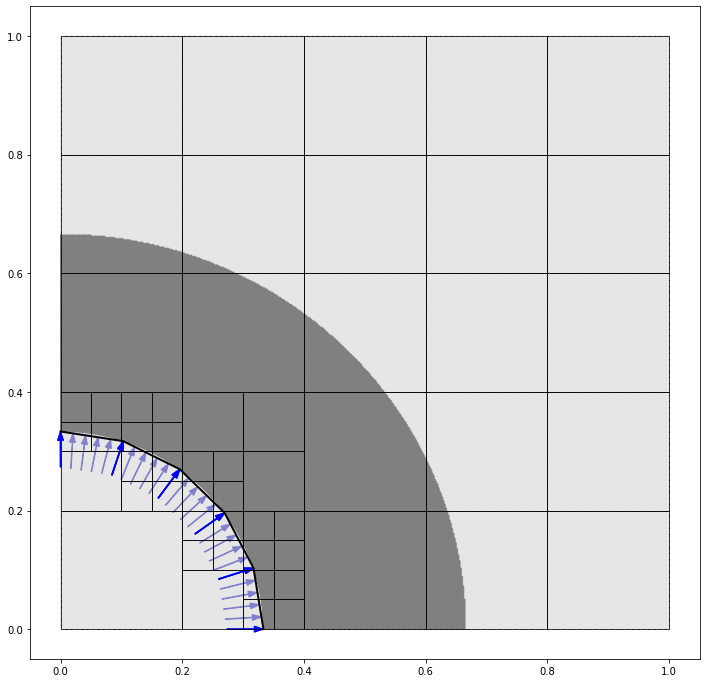

In [19]:
# Plot immersed boundary mesh on background mesh

fig, ax = NewFigure()
fname = "cyl_immersed_boundary_and_background_meshes"
PlotMesh(ax, refined_omega_topo, omega.x, shading=omega.wall, linewidth=1)
PlotLine(ax, gamma_topo, gamma.x, linecolor='k', linewidth=2.0)
PlotVectors(ax, gamma_topo, gamma.x, gamma.traction, res=6, scale=5, color=(0.5,0.5,0.8), width=0.001, headwidth=10)
PlotVectors(ax, gamma_topo, gamma.x, gamma.traction, res=2, scale=5, color='b', width=0.001, headwidth=10)


ExportPlot(fig, ax, fdir, fname)

saved Figures/immersed_boundary_and_background_meshes.png


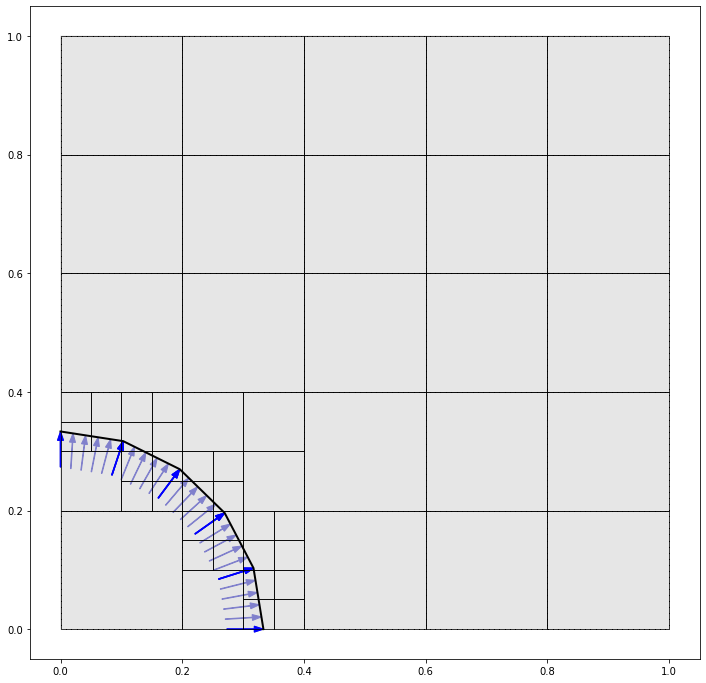

In [20]:
# Plot immersed boundary mesh on background mesh

fig, ax = NewFigure()
fname = "immersed_boundary_and_background_meshes"
PlotMesh(ax, refined_omega_topo, omega.x, linewidth=1)
PlotLine(ax, gamma_topo, gamma.x, linecolor='k', linewidth=2.0)
PlotVectors(ax, gamma_topo, gamma.x, gamma.traction, res=6, scale=5, color=(0.5,0.5,0.8), width=0.001, headwidth=10)
PlotVectors(ax, gamma_topo, gamma.x, gamma.traction, res=2, scale=5, color='b', width=0.001, headwidth=10)


ExportPlot(fig, ax, fdir, fname)

saved Figures/immersed_boundary_and_background_meshes_no_tractions.png


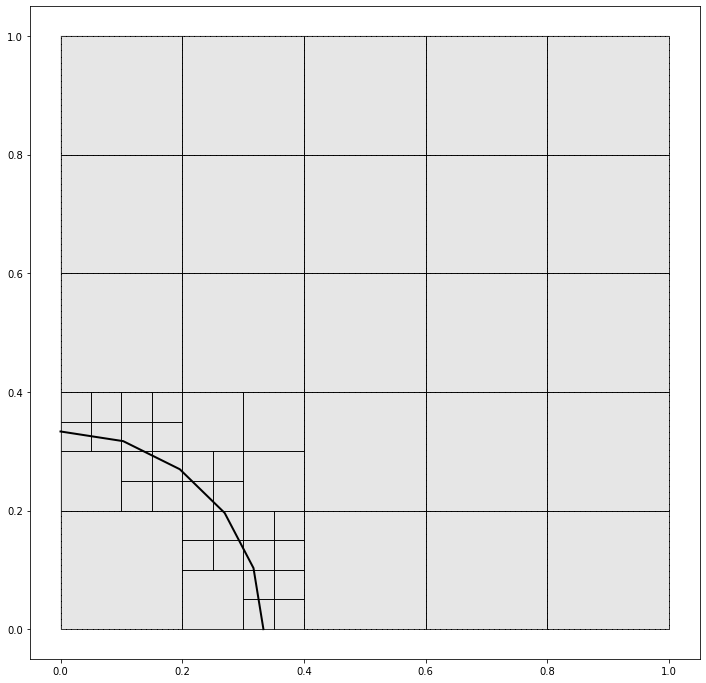

In [21]:
# Plot immersed boundary mesh on background mesh

fig, ax = NewFigure()
fname = "immersed_boundary_and_background_meshes_no_tractions"
PlotMesh(ax, refined_omega_topo, omega.x, linewidth=1)
PlotLine(ax, gamma_topo, gamma.x, linecolor='k', linewidth=2.0)


ExportPlot(fig, ax, fdir, fname)

saved Figures/immersed_boundary_and_unrefined_background_meshes_no_tractions.png


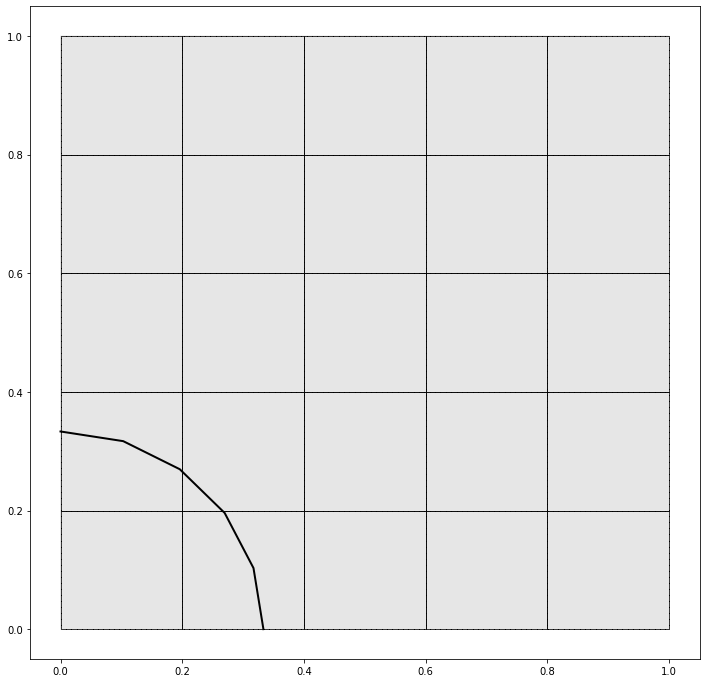

In [22]:
# Plot immersed boundary mesh on background mesh

fig, ax = NewFigure()
fname = "immersed_boundary_and_unrefined_background_meshes_no_tractions"
PlotMesh(ax, omega_topo, omega.x, linewidth=1)
PlotLine(ax, gamma_topo, gamma.x, linecolor='k', linewidth=2.0)


ExportPlot(fig, ax, fdir, fname)

saved Figures/immersed_boundary_and_background_meshes_unrefined.png


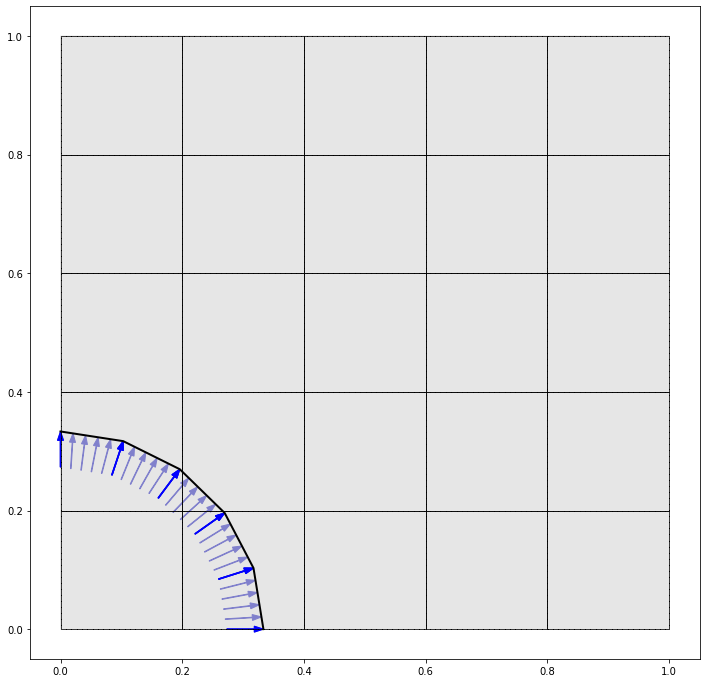

In [23]:
# Plot immersed boundary mesh on background mesh

fig, ax = NewFigure()
fname = "immersed_boundary_and_background_meshes_unrefined"
PlotMesh(ax, omega_topo, omega.x, linewidth=1)
PlotLine(ax, gamma_topo, gamma.x, linecolor='k', linewidth=2.0)
PlotVectors(ax, gamma_topo, gamma.x, gamma.traction, res=6, scale=5, color=(0.5,0.5,0.8), width=0.001, headwidth=10)
PlotVectors(ax, gamma_topo, gamma.x, gamma.traction, res=2, scale=5, color='b', width=0.001, headwidth=10)


ExportPlot(fig, ax, fdir, fname)

saved Figures/body_fitted_polar_mesh.png


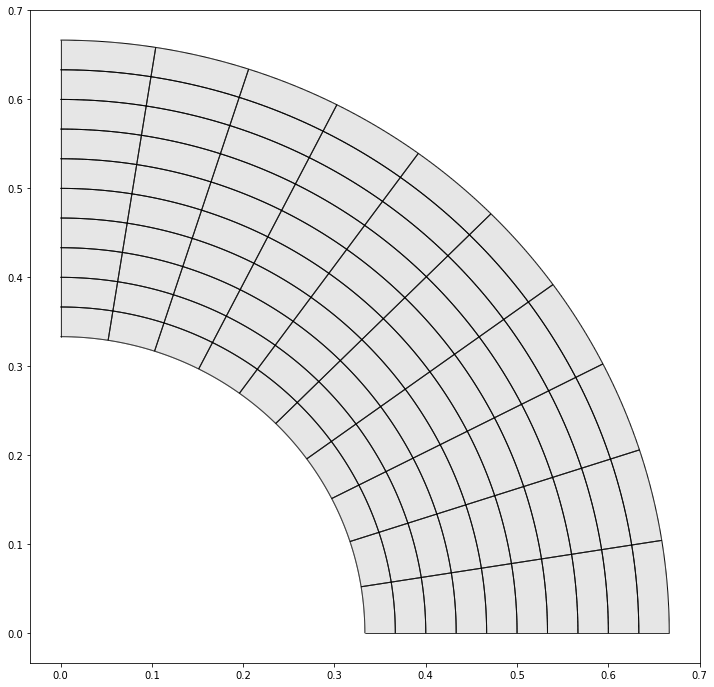

In [6]:
Nt = 10
Nr = 10

th = np.linspace(0, np.pi/2, Nt + 1)
r = np.linspace(ri,ro,Nr+1)

bf = function.Namespace()
bf_topo, bf.uv = mesh.rectilinear([th,r])
bf.x_i = '<uv_1 cos(uv_0) , uv_1 sin(uv_0) >_i'

fig, ax = NewFigure()
fname = "body_fitted_polar_mesh"
PlotMesh(ax, bf_topo, bf.x, linewidth=1)
ExportPlot(fig, ax, fdir, fname)